In [1]:
############# MAINLY FOR COLAB
import Pkg
Pkg.activate("./")
Pkg.develop("BackAction")
Pkg.instantiate()
Pkg.add()

  Activating project at `~/Documents/Research/MonitoringMetrology/BackAction.jl/notebooks`
  No Changes to `~/Documents/Research/MonitoringMetrology/BackAction.jl/notebooks/Project.toml`
  No Changes to `~/Documents/Research/MonitoringMetrology/BackAction.jl/notebooks/Manifest.toml`


In [16]:
using Plots, LinearAlgebra, BackAction

In [2]:
const DELTA_GAMMELMARK::Vector{Float64} = 0.2/0.478 * [0.146,0.262,0.383,0.511,0.648,0.806,0.965,1.118,1.287,1.438,1.596,
               1.755,1.888, 2.057, 2.206, 2.381, 2.539, 2.682, 2.865, 3.013, 3.174, 3.334, 3.452]
const FI_GAMMELMARK::Vector{Float64} = [0.115, 0.221, 0.338, 0.425, 0.507, 0.557, 0.573, 0.566, 0.532, 0.494,
                   0.448, 0.403, 0.363, 0.318, 0.281, 0.241, 0.210, 0.186, 0.156, 0.137, 0.115, 0.101, 0.09348];

In [3]:
const NCHANNELS0::Int64 = 1
#const NCHANNELS::Int64 = 1
const NLEVELS::Int64 = 2
const OMEGA = 1.0
const GAMMA = 0.5

0.5

In [4]:
# Set up the unravelings
function sample_c2(seed)
    theta = pi*rand()
    phi = 2*pi*rand()
    return [cos(theta*0.5); exp(1im*phi)*sin(theta*0.5)] 
end
function get_random_unraveling(seed)
    Random.seed!(seed)
    T = sample_c2(seed) 
    T = reshape(T/norm(T), 2,1)
    T_curvy = [real(T[1]) imag(T[1]); real(T[2]) imag(T[2]) ]
    F = svd(T_curvy) # Factorization object
    P = F.V * Diagonal(F.S) * F.Vt
    O = F.U * F.Vt
    T_curvy_dyne = O' * T_curvy
    T_dyne = O' * real.(T) + 1im * O' * imag.(T)
    Ta = T 
    Tb = T_dyne 
    Tc = T_dyne 
    Ts = Dict([("a", Ta), ("b", Tb), ("c", Tc)]) # Dictionary with the Ts
    alpha0 = [0.5 + 0im; 0.5 + 0im] 
    alphas = Dict([("a", alpha0), ("b", alpha0), ("c", O' * alpha0)]) # Dictionary with the alphas

    return Ts, alphas
end


get_random_unraveling (generic function with 1 method)

In [17]:
# Base parametric operators

L0 = d -> sqrt(GAMMA) * BackAction.sigma_m
H0 = d -> d*[[0, 0] [0, 1.0+0im]]  + 0.5*OMEGA*BackAction.sigma_x 

# Unraveling parametrix operators
function obtain_parametric_unraveling_operators(T::Matrix{T1}, alpha::Vector{T1}) where {T1<:Complex}
    # First do the unitary mixing 
    Ls_mixed = BackAction.isometric_mixing([L0], T, NLEVELS, size(T)[1])
    H = BackAction.add_cfield_hamiltonian_correctionterm(H0, Ls_mixed, alpha, NLEVELS)
    Ls_mixed_cfield = BackAction.add_cfields(Ls_mixed, alpha, NLEVELS)
    He = BackAction.get_Heff(H, Ls_mixed_cfield, NLEVELS)
    return Ls_mixed_cfield, H, He
end

#function evaluate_and_fill_Ls!(Ls::Vector{TJ}, theta::T2,
#        Ls_store::Array{T1}, nchannels::T3) where {T1<:Complex, T2<:Real, T3<:Int,TJ<:Function} 
#    for k in nchannels
#       Ls_store[:,:, k] .= Ls[k](theta) 
#    end 
#end 

evaluate_and_fill_Ls! (generic function with 1 method)

In [18]:
function calculate_fi(ensol)
    avg = 0.0
    for sol in ensol 
        psi = sol.u[end]/norm(sol.u[end])
        phi = sol.prob.kwargs[:callback].affect!.cache_phi
        avg = avg + (2*real(dot(psi, phi)))^2
    end
    return avg/length(ensol) 
end 

calculate_fi (generic function with 1 method)

In [21]:
function FisherInformationRoutine(theta::T2, dtheta::T2, tf::T2, T::Matrix{T1}, alpha::Vector{T1}, nchannels::T3,
        Ls::Array{T1}, dLs::Array{T1}, ntraj::T3) where {T1<:Complex, T2<:Real, T3<:Int}
    
    params_simul = BackAction.SimulParameters([0.0+0im, 1.0],
        tf, # Final time. Set very long so that all trajectories jump
        1, # seed
        ntraj, # Number of trajectories
        # GILLIPSIE STUFF 
        75_000, 3.0, 1e-3 )
    tspan = (0.0, tf)
    ## 1. define the T and alpha
    #T = reshape([1.0+0im], 1,1) # MUST BE CONSISTENT WITH THE DIMENSIONS OF ALPHA
    #alpha = [0.0+0im]
    #nchannels = length(alpha)
    ## 2. Obtain the parametrizations of Ls, H and He
    Ls_par, H_par, He_par = obtain_parametric_unraveling_operators(T, alpha)
    ## 3. Evaluate the parametrizations
    ##Ls = Array{ComplexF64}(undef, NLEVELS, NLEVELS, nchannels)
    #evaluate_and_fill_Ls!(Ls_par, delta, Ls, nchannels)
    evaluate_and_fill_Ls_dLs(Ls_par, theta, Ls, dLs, nchannels)
    ### 4. Initialzie the system
    sys = System(H_par(theta), Ls, NLEVELS, nchannels)
    ## Set up the derivatives of the jump operators
    #dLs = Array{ComplexF64}(undef, NLEVELS, NLEVELS, nchannels)
    #for k in 1:nchannels
    #    ForwardDiff.derivative!(view(dLs, :, :, k), Ls_par[k], GAMMA)
    #end
    ## Information for the derivatives
    #dtheta = delta/1000
    He_forward = He_par(theta + 0.5*dtheta )
    He_backward = He_par(theta - 0.5*dtheta)
    #
    sim = get_sol_jumps_monitoring(dtheta, dLs, He_forward, He_backward, sys, params_simul, tspan; 
                                    save_on=false, save_start=false, save_end=true)
    return calculate_fi(sim)/tf
end

FisherInformationRoutine (generic function with 2 methods)

In [24]:
T = reshape([1.0+0im], 1,1) # MUST BE CONSISTENT WITH THE DIMENSIONS OF ALPHA
alpha = [0.0+0im]
nchannels = length(alpha)
Ls = Array{ComplexF64}(undef, NLEVELS, NLEVELS, nchannels)
dLs = Array{ComplexF64}(undef, NLEVELS, NLEVELS, nchannels)
theta = DELTA_GAMMELMARK[1]
dtheta = theta/1000
tf = 300.0
ntraj = 1_000

FisherInformationRoutine(theta, dtheta,tf, T, alpha, nchannels, Ls, dLs, ntraj)

0.11007503793866046

In [38]:
[alphas[1]+0.0im]

1-element Vector{ComplexF64}:
 0.0 + 0.0im

In [44]:
ndeltas = length(DELTA_GAMMELMARK)
nalphas = 20
alphamax = 2.0 + 0.0im
dalphas = alphamax/nalphas
alphas = [dalphas*m for m in 0:nalphas]
myfi = Array{Float64}(undef, ndeltas, nalphas)
@time begin
    for k in 1:nalphas
        println(alphas[k])
    @time begin
            for n in 1:ndeltas
               myfi[n, k] = FisherInformationRoutine(DELTA_GAMMELMARK[n], DELTA_GAMMELMARK[n]/1000, tf, T, [alphas[k]], nchannels, Ls, dLs, ntraj) 
            end 
        end
    end
end

0.0 + 0.0im
 32.103846 seconds (789.80 M allocations: 25.197 GiB, 21.84% gc time)
0.1 + 0.0im
 31.254000 seconds (660.35 M allocations: 20.879 GiB, 20.13% gc time)
0.2 + 0.0im
 26.580335 seconds (596.67 M allocations: 18.996 GiB, 19.97% gc time)
0.30000000000000004 + 0.0im
 28.069359 seconds (640.26 M allocations: 20.610 GiB, 21.53% gc time)
0.4 + 0.0im
 35.652721 seconds (778.55 M allocations: 25.416 GiB, 21.19% gc time)
0.5 + 0.0im
 44.618544 seconds (979.45 M allocations: 32.549 GiB, 20.86% gc time)
0.6000000000000001 + 0.0im
 57.479770 seconds (1.24 G allocations: 41.875 GiB, 20.85% gc time)
0.7000000000000001 + 0.0im
 68.741493 seconds (1.55 G allocations: 53.464 GiB, 21.37% gc time)
0.8 + 0.0im
 82.527913 seconds (1.92 G allocations: 67.155 GiB, 22.00% gc time)
0.9 + 0.0im
102.786687 seconds (2.35 G allocations: 83.197 GiB, 21.99% gc time)
1.0 + 0.0im
144.962638 seconds (2.84 G allocations: 101.803 GiB, 20.40% gc time)
1.1 + 0.0im
202.954294 seconds (3.40 G allocations: 122.861 G

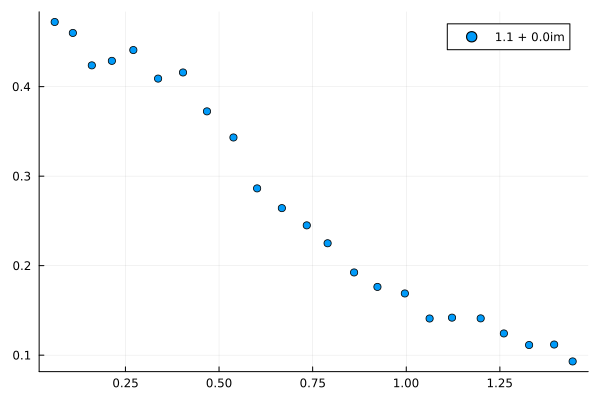

In [62]:
k = 13
scatter(DELTA_GAMMELMARK, myfi[:, k], label="$(alphas[k])")